## Variational Autoencoder

### Libraries

In [1]:
import math
import numpy as np
import torch
import pandas as pd
from scipy.spatial.distance import cdist
from typing import Dict, Any, Tuple
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions import Normal
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict
from BatchEffectDataLoader import DataTransform, DataPreprocess
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
sns.set_style("whitegrid")

### Reparametirization trick

$$
N(y | \mu, \sigma) = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim N(0, 1)
$$

In [3]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    The choosen distribution must be compatible with the reparameterization trick (epsilon ~ N(0,1))
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()

    def sample_epsilon(self) -> Tensor:
        """epsilon ~ N(0, I)"""
        return torch.empty_like(self.mu).normal_()

    def sample(self) -> Tensor:
        """sample z ~ N(z | mu, sigma) (without gradients)"""
        with torch.no_grad():
            return self.rsample()

    def rsample(self) -> Tensor:
        """sample z ~ N(z | mu, sigma) (with the reparameterization trick) """
        epsilon = self.sample_epsilon() #Capture the epsilon value from the distribution N(0, I)
        return self.mu + self.sigma * epsilon #Sampling from the distribution using the reparameterization trick

    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log p(z)"""
        return -self.sigma.log() - 0.5 * math.log(2 * math.pi) - ((z - self.mu)**2 / (2 * self.sigma**2))

### Variational Autoencoder

In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape: torch.Size, latent_features: int) -> None:
        super(VariationalAutoencoder, self).__init__()

        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observations_features = np.prod(input_shape)

        # Inference network (Encoder)
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observations_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=2 * latent_features)
        )

        # Generative network (Decoder)
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observations_features),
            nn.Softplus()
        )

        # Prior parameters
        self.register_buffer("prior_params", torch.zeros(torch.Size([1, 2 * latent_features])))

    def posterior(self, x:Tensor) -> Distribution:
        h_x = self.encoder(x)
        mu, log_sigma = h_x.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size: int=1) -> Distribution:
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z: Tensor) -> Distribution:
        px_mean = self.decoder(z)
        return Normal(loc=px_mean, scale=torch.ones_like(px_mean))

    def forward(self, x) -> Dict[str, Any]:
        x = x.view(x.size(0), -1)
        qz = self.posterior(x)
        pz = self.prior(batch_size=x.size(0))
        z = qz.rsample()
        px = self.observation_model(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

    def sample_from_prior(self, batch_size: int = 100):
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {'px': px, 'pz': pz, 'z': z}

### Variational Inference Evaluator

In [ ]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta

    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:

        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        # compute the ELBO with and without the beta parameter:
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta*kl # <- your code here # add penalizing term for batch effect

        # loss
        loss = -beta_elbo.mean()

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}

        return loss, diagnostics, outputs

### Data preprocessing

In [6]:
path = "data/dataset_sponge.csv"
raw_data = DataPreprocess(path)
data = DataTransform(raw_data)

otu_data = data.select_dtypes(include = "number")
otu_tensor = torch.tensor(otu_data.values, dtype = torch.float32)

dataset = TensorDataset(otu_tensor)
dataloader = DataLoader(dataset, batch_size = 32) #Full batch training


### Model setup

In [65]:
# Variational Autoencoder
vae = VariationalAutoencoder(input_shape = otu_tensor.shape[1:], latent_features= 2 )
# Variational Inference
vi = VariationalInference(beta = 1)
# Optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr = 0.001)

### Training loop

Epoch 1/1000, Loss: 963.1418
Epoch 2/1000, Loss: 961.4667
Epoch 3/1000, Loss: 959.9429
Epoch 4/1000, Loss: 957.6990
Epoch 5/1000, Loss: 954.4369
Epoch 6/1000, Loss: 950.4657
Epoch 7/1000, Loss: 946.3970
Epoch 8/1000, Loss: 938.6674
Epoch 9/1000, Loss: 927.4051
Epoch 10/1000, Loss: 920.2171
Epoch 11/1000, Loss: 913.7721
Epoch 12/1000, Loss: 896.9181
Epoch 13/1000, Loss: 877.2438
Epoch 14/1000, Loss: 869.8958
Epoch 15/1000, Loss: 839.5674
Epoch 16/1000, Loss: 826.9603
Epoch 17/1000, Loss: 846.1783
Epoch 18/1000, Loss: 803.2297
Epoch 19/1000, Loss: 796.1121
Epoch 20/1000, Loss: 802.4758
Epoch 21/1000, Loss: 781.2917
Epoch 22/1000, Loss: 782.8569
Epoch 23/1000, Loss: 779.6481
Epoch 24/1000, Loss: 775.5447
Epoch 25/1000, Loss: 773.3367
Epoch 26/1000, Loss: 767.8654
Epoch 27/1000, Loss: 762.6672
Epoch 28/1000, Loss: 760.5046
Epoch 29/1000, Loss: 761.6473
Epoch 30/1000, Loss: 759.0397
Epoch 31/1000, Loss: 758.3847
Epoch 32/1000, Loss: 755.5487
Epoch 33/1000, Loss: 755.8659
Epoch 34/1000, Loss

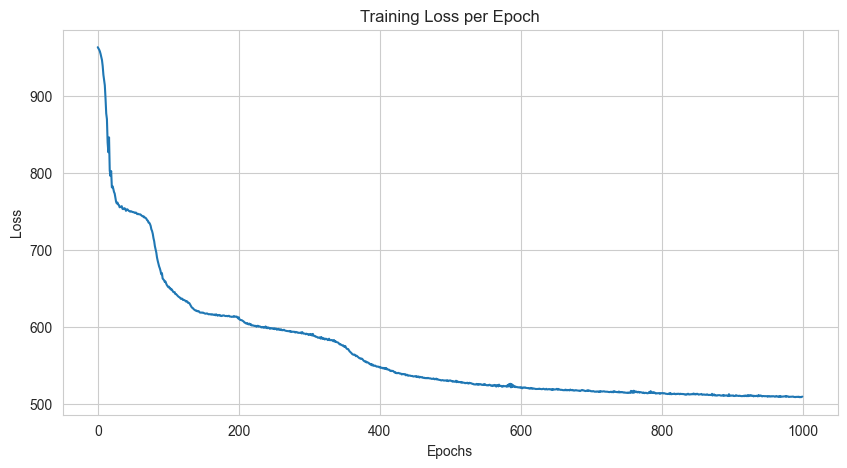

/var/folders/m3/pvgjtgln0_9gnm2lzvzlvr100000gp/T/ipykernel_86264/4219069785.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 2)


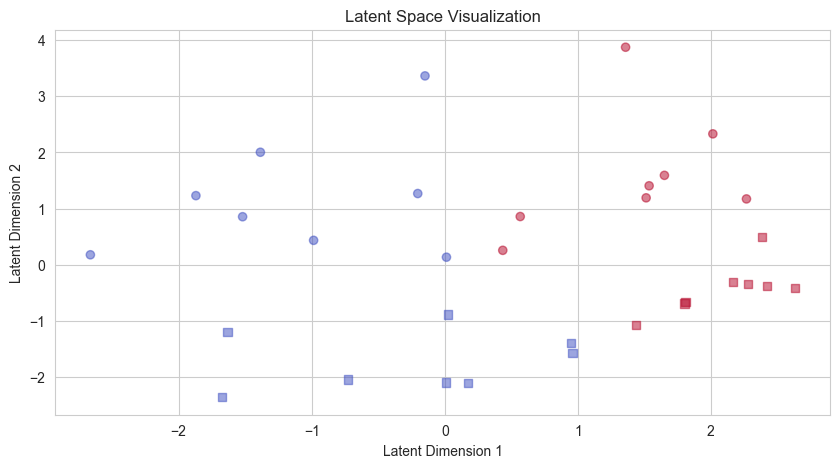

In [66]:
import random

#random.seed(42)
# For storing training curve and latent variables
training_data = defaultdict(list)
latent_variables = []

# Training parameters
epochs = 1000

# TRAINING STARTS HERE
vae.train()

for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        # Extract data from the batch
        x = batch[0]  # (batch_size, input_dim)

        # Zero gradients
        optimizer.zero_grad()

        # Compute the loss
        loss, diagnostics, outputs = vi(vae, x)

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Store the loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    training_data['loss'].append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Extract latent variables (z) for later visualization
latent_variables.append(outputs['z'].cpu().detach())

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(training_data['loss'])
plt.title("Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plotting the latent space (using PCA for dimensionality reduction if needed)
latent_variables = torch.cat(latent_variables, dim=0)

# If latent features > 2, apply PCA to reduce to 2D
if latent_variables.shape[1] > 2:
    pca = PCA(n_components=2)
    latent_variables_2d = pca.fit_transform(latent_variables).cpu().numpy()
else:
    latent_variables_2d = latent_variables.cpu().detach()

latent_variables_2d_list = latent_variables_2d.tolist()

pc1_latent = [row[0] for row in latent_variables_2d_list]
pc2_latent = [row[1] for row in latent_variables_2d_list]

# Plot the 2D latent space
tissue_label = data["tissue"].values.tolist()
tissue_label = ["circle" if tissue_label[i] == "Ectosome" else "square" for i in range(len(tissue_label))]

batch_label = data["batch"].values.tolist()
batch_label = [1 if batch_label[i] == 1 else 0 for i in range(len(batch_label))]

cmap = plt.cm.get_cmap('coolwarm', 2)
markers = {'circle': 'o', 'square': 's'}

plt.figure(figsize=(10, 5))

# Plot each group separately based on the shape and tissue
for i, shape in enumerate(set(tissue_label)):
    mask = [label == shape for label in tissue_label]
    plt.scatter(
        [pc1_latent[j] for j in range(len(pc1_latent)) if mask[j]], 
        [pc2_latent[j] for j in range(len(pc2_latent)) if mask[j]], 
        c=[batch_label[j] for j in range(len(batch_label)) if mask[j]], 
        cmap=cmap, 
        alpha=0.5, 
        marker=markers[shape]
    )

plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

## Simple AutoEncoder with batch effect penalization

In [7]:
# Defining AE
class AutoEncoder(nn.Module):
    def __init__(self, input_shape: torch.Size, latent_features: int) -> None:
        super(AutoEncoder, self).__init__()

        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observations_features = np.prod(input_shape)

        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observations_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=self.latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observations_features)
        )
    
    def forward(self, x):
        outputs = {}
        z = self.encoder(x)
        output = self.decoder(z)

        return {
            'output': output,
            'z': z
        }

In [45]:
# Defining loss component
def compute_loss(x, x_pred, latent, tissue_label, batch_label, w_mse = 1, w_batch = 1):
    # Define reconstruction loss
    loss_function = nn.MSELoss()
    rec_loss = loss_function(x_pred, x)

    # Define batch penalization
    batch_loss = []
    for tissue in tissue_label.unique():
        group_points = []
        for batch_unique in batch_label.unique():
            points = []
            for i, batch in enumerate(batch_label):
                if (tissue_label[i] == tissue) & (batch == batch_unique):
                    points.append(latent[i])
            group_points.append(torch.stack(points))
        #Statistical difference among distributions
        dist = torch.cdist(group_points[0], group_points[1], p = 2)
        batch_loss.append(torch.mean(dist))
    batch_loss = torch.mean(torch.stack(batch_loss))

    #Return loss
    return (w_mse*rec_loss + w_batch*batch_loss)

In [78]:
path = "data/dataset_sponge.csv"
raw_data = DataPreprocess(path)
data = DataTransform(raw_data)

otu_data = data.select_dtypes(include = "number")
otu_tensor = torch.tensor(otu_data.values, dtype = torch.float32)

dataset = TensorDataset(otu_tensor)
dataloader = DataLoader(dataset, batch_size = 32) #Full batch training

tissue_label_label = data["tissue"]
batch_label_label = data["batch"]

In [123]:
# Variational Autoencoder
model = AutoEncoder(input_shape = otu_tensor.shape[1:], latent_features= 2)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Epoch 1/1000, Loss: 77.9516


Epoch 2/1000, Loss: 77.6292
Epoch 3/1000, Loss: 77.3806
Epoch 4/1000, Loss: 77.0945
Epoch 5/1000, Loss: 76.7720
Epoch 6/1000, Loss: 76.3319
Epoch 7/1000, Loss: 75.7064
Epoch 8/1000, Loss: 74.8072
Epoch 9/1000, Loss: 73.5133
Epoch 10/1000, Loss: 71.6804
Epoch 11/1000, Loss: 69.1542
Epoch 12/1000, Loss: 65.8311
Epoch 13/1000, Loss: 61.6704
Epoch 14/1000, Loss: 56.9177
Epoch 15/1000, Loss: 52.4344
Epoch 16/1000, Loss: 50.2263
Epoch 17/1000, Loss: 52.3876
Epoch 18/1000, Loss: 53.7763
Epoch 19/1000, Loss: 51.7095
Epoch 20/1000, Loss: 48.8486
Epoch 21/1000, Loss: 47.1570
Epoch 22/1000, Loss: 46.8597
Epoch 23/1000, Loss: 47.3186
Epoch 24/1000, Loss: 47.8883
Epoch 25/1000, Loss: 48.2221
Epoch 26/1000, Loss: 48.2251
Epoch 27/1000, Loss: 47.9534
Epoch 28/1000, Loss: 47.5537
Epoch 29/1000, Loss: 47.2198
Epoch 30/1000, Loss: 47.1199
Epoch 31/1000, Loss: 47.2874
Epoch 32/1000, Loss: 47.5484
Epoch 33/1000, Loss: 47.6323
Epoch 34/1000, Loss: 47.4245
Epoch 35/1000, Loss: 47.0537
Epoch 36/1000, Loss: 4

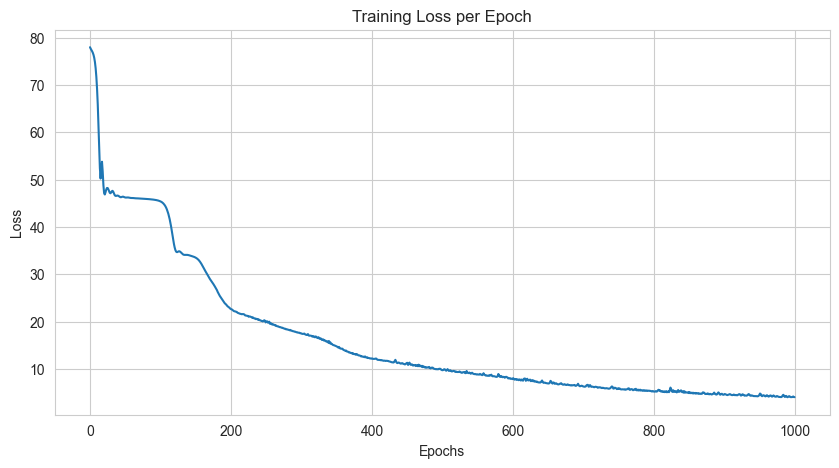

In [124]:
# Training parameters
epochs = 1000

# For storing training curve and latent variables
training_data = defaultdict(list)
latent_variables = []

# TRAINING STARTS HERE
model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        # Extract data from the batch
        x = batch[0]  # (batch_size, input_dim)

        # Zero gradients
        optimizer.zero_grad()

        outputs = model(otu_tensor)

        x_hat = outputs["output"]
        latent = outputs["z"]

        #Compute loss
        loss = compute_loss(otu_tensor, x_hat, latent, tissue_label_label, batch_label_label, w_mse = 1, w_batch=0.5)

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Store the loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    training_data['loss'].append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Extract latent variables (z) for later visualization
latent_variables.append(outputs['z'].cpu().detach())

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(training_data['loss'])
plt.title("Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/var/folders/m3/pvgjtgln0_9gnm2lzvzlvr100000gp/T/ipykernel_13860/3499895660.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 2)


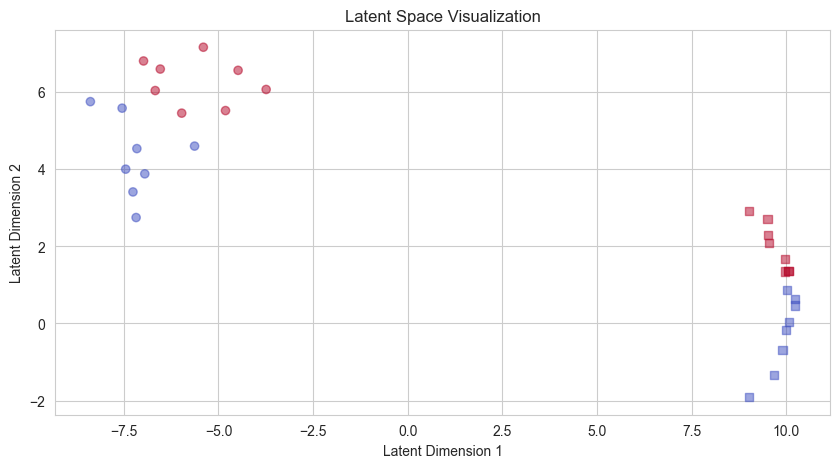

In [125]:
# Plotting the latent space (using PCA for dimensionality reduction if needed)
latent_variables = torch.cat(latent_variables, dim=0)

# If latent features > 2, apply PCA to reduce to 2D
if latent_variables.shape[1] > 2:
    pca = PCA(n_components=2)
    latent_variables_2d = pca.fit_transform(latent_variables).cpu().numpy()
else:
    latent_variables_2d = latent_variables.cpu().detach()

latent_variables_2d_list = latent_variables_2d.tolist()

pc1_latent = [row[0] for row in latent_variables_2d_list]
pc2_latent = [row[1] for row in latent_variables_2d_list]

# Plot the 2D latent space
tissue_label = data["tissue"].values.tolist()
tissue_label = ["circle" if tissue_label[i] == "Ectosome" else "square" for i in range(len(tissue_label))]

batch_label = data["batch"].values.tolist()
batch_label = [1 if batch_label[i] == 1 else 0 for i in range(len(batch_label))]

cmap = plt.cm.get_cmap('coolwarm', 2)
markers = {'circle': 'o', 'square': 's'}

plt.figure(figsize=(10, 5))

# Plot each group separately based on the shape and tissue
for i, shape in enumerate(set(tissue_label)):
    mask = [label == shape for label in tissue_label]
    plt.scatter(
        [pc1_latent[j] for j in range(len(pc1_latent)) if mask[j]], 
        [pc2_latent[j] for j in range(len(pc2_latent)) if mask[j]], 
        c=[batch_label[j] for j in range(len(batch_label)) if mask[j]], 
        cmap=cmap, 
        alpha=0.5, 
        marker=markers[shape]
    )

plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()